In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("FD_Recommendation_Clustering") \
    .getOrCreate()

df = spark.read.csv("100k_final_table_for_fd_recommendation_system.csv", header=True, inferSchema=True)
df.printSchema()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/10 09:34:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/10 09:34:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- cif_id: string (nullable = true)
 |-- total_accounts: integer (nullable = true)
 |-- total_saving_accounts: integer (nullable = true)
 |-- total_fixed_accounts: integer (nullable = true)
 |-- total_loan_accounts: integer (nullable = true)
 |-- total_overdraft_accounts: integer (nullable = true)
 |-- scheme_type: string (nullable = true)
 |-- total_debit_transaction_count: double (nullable = true)
 |-- total_credit_transaction_count: double (nullable = true)
 |-- average_debit_transaction_count: integer (nullable = true)
 |-- average_credit_transaction_count: integer (nullable = true)
 |-- total_debit_transaction_amount: double (nullable = true)
 |-- total_credit_transaction_amount: double (nullable = true)
 |-- average_debit_amount: double (nullable = true)
 |-- average_credit_amount: double (nullable = true)
 |-- average_yearly_saving: double (nullable = true)
 |-- total_yearly_saving: double (nullable = true)
 |-- employment_status: string (nullable = true)
 |-- marital_sta

In [5]:
from pyspark.sql.functions import expr

numeric_cols = [
    'total_accounts',
    'total_saving_accounts',
    'total_fixed_accounts',
    'total_loan_accounts',
    'total_overdraft_accounts',
    'total_debit_transaction_count',
    'total_credit_transaction_count',
    'average_debit_transaction_count',
    'average_credit_transaction_count',
    'total_debit_transaction_amount',
    'total_credit_transaction_amount',
    'average_debit_amount',
    'average_credit_amount',
    'average_yearly_saving',
    'total_yearly_saving',
    'total_dormant_account',
    'total_dormant_days',
    'total_active_account'
]

# Calculate medians efficiently
median_dict = {
    col_name: df.approxQuantile(col_name, [0.5], 0.01)[0] 
    for col_name in numeric_cols
}

# Fill missing numeric values
df = df.fillna(median_dict)


In [8]:
# Identify categorical columns with > 1 unique value
valid_categorical_cols = []
for col_name in categorical_cols:
    distinct_count = df.select(col_name).distinct().count()
    if distinct_count > 1:
        valid_categorical_cols.append(col_name)
    else:
        print(f"Skipping '{col_name}' - only one distinct value.")

# Create pipeline stages for valid categorical columns only
stages = []
for col in valid_categorical_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_idx")
    encoder = OneHotEncoder(inputCols=[col+"_idx"], outputCols=[col+"_encoded"])
    stages.extend([indexer, encoder])

# Vector Assembling
feature_cols = numeric_cols + [col+"_encoded" for col in valid_categorical_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_unscaled")
stages.append(assembler)

pipeline = Pipeline(stages=stages)
df_processed = pipeline.fit(df).transform(df)

# Standard Scaling
scaler = StandardScaler(inputCol="features_unscaled", outputCol="scaled_features")
scaler_model = scaler.fit(df_processed)
df_final = scaler_model.transform(df_processed)


Skipping 'scheme_type' - only one distinct value.


25/03/10 10:08:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


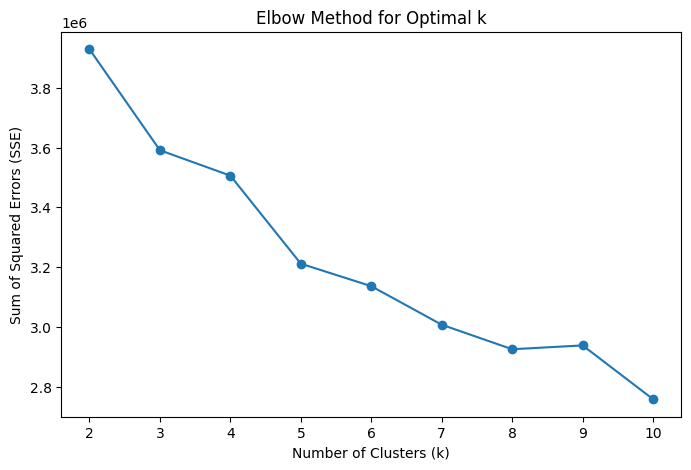

In [10]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

sse = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
    model = kmeans.fit(df_final)
    sse.append(model.summary.trainingCost)

# Plot SSE for Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()


In [11]:
optimal_k = 6  # or 7 based on preference

from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42)
final_model = kmeans.fit(df_final)

# Assign cluster labels
df_clustered = final_model.transform(df_final)
df_clustered.select('cif_id', 'prediction').show(10)


+--------------+----------+
|        cif_id|prediction|
+--------------+----------+
|DLNINDV8461369|         4|
|DLNINDV7781452|         5|
|DLNINDV7340461|         4|
|DLNINDV3651024|         1|
|DLNINDV7150159|         1|
|DLNINDV4459472|         5|
|DLNINDV1124347|         5|
|DLNINDV7266537|         3|
|DLNINDV4508435|         5|
|DLNINDV5379397|         5|
+--------------+----------+
only showing top 10 rows



In [12]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='scaled_features', metricName='silhouette')
silhouette_score = evaluator.evaluate(df_clustered)
print(f"Silhouette Score for k={optimal_k}: {silhouette_score}")


Silhouette Score for k=6: 0.2750888939259526


In [13]:
df_clustered.groupBy('prediction').mean().show()


+----------+-------------------+--------------------------+-------------------------+------------------------+-----------------------------+----------------------------------+-----------------------------------+------------------------------------+-------------------------------------+-----------------------------------+------------------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------------+-----------------------------+-----------------------+--------------------------+-------------------------+--------------------------+-----------------------+-------------------+-------------------+------------------+--------------------------+------------------------+---------------+
|prediction|avg(total_accounts)|avg(total_saving_accounts)|avg(total_fixed_accounts)|avg(total_loan_accounts)|avg(total_overdraft_accounts)|avg(total_debit_transaction_count)|avg(total_credit_transaction_count)|avg(aver

In [15]:
import pandas as pd

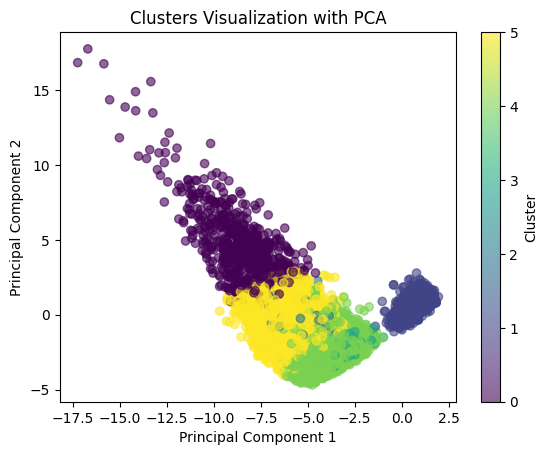

In [16]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
df_pca = pca.fit(df_clustered).transform(df_clustered)

# Convert PCA results to pandas for visualization
pdf = df_pca.select('pca_features', 'prediction').sample(0.1, seed=42).toPandas()
pdf[['pca_1', 'pca_2']] = pd.DataFrame(pdf['pca_features'].tolist(), index=pdf.index)

import matplotlib.pyplot as plt
plt.scatter(pdf['pca_1'], pdf['pca_2'], c=pdf['prediction'], cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization with PCA')
plt.colorbar(label='Cluster')
plt.show()


In [17]:
df_clustered.groupBy('prediction').mean().show()


+----------+-------------------+--------------------------+-------------------------+------------------------+-----------------------------+----------------------------------+-----------------------------------+------------------------------------+-------------------------------------+-----------------------------------+------------------------------------+-------------------------+--------------------------+--------------------------+------------------------+------------------------------+-----------------------------+-----------------------+--------------------------+-------------------------+--------------------------+-----------------------+-------------------+-------------------+------------------+--------------------------+------------------------+---------------+
|prediction|avg(total_accounts)|avg(total_saving_accounts)|avg(total_fixed_accounts)|avg(total_loan_accounts)|avg(total_overdraft_accounts)|avg(total_debit_transaction_count)|avg(total_credit_transaction_count)|avg(aver

In [18]:
df_clustered.groupBy("prediction", "scheme_type").count().show()
df_clustered.groupBy("prediction", "employment_status").count().show()


+----------+-----------+-----+
|prediction|scheme_type|count|
+----------+-----------+-----+
|         4|        SBA|39526|
|         1|        SBA|21797|
|         2|        SBA| 1058|
|         0|        SBA| 6014|
|         5|        SBA|30353|
|         3|        SBA| 1252|
+----------+-----------+-----+



+----------+-----------------+-----+
|prediction|employment_status|count|
+----------+-----------------+-----+
|         3|         Employed| 1252|
|         1|         Employed|    2|
|         5|         Employed|27079|
|         0|    Self-employed| 4521|
|         5|    Self-employed| 3274|
|         1|       Unemployed|21792|
|         1|    Self-employed|    3|
|         0|         Employed| 1493|
|         4|    Self-employed|  354|
|         4|         Employed|39172|
|         2|         Employed| 1058|
+----------+-----------------+-----+



In [19]:
def recommend_fd(cluster):
    if cluster == 0:
        return "Long-Term FD (5+ Years)"
    elif cluster == 1:
        return "Short-Term FD (1 Year)"
    elif cluster == 2:
        return "Recurring Deposit"
    elif cluster == 3:
        return "Low-Risk Savings Plan"
    elif cluster == 4:
        return "High-Interest FD"
    else:
        return "Standard FD"
        
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

recommend_udf = udf(recommend_fd, StringType())
df_clustered = df_clustered.withColumn("FD_Recommendation", recommend_udf(df_clustered["prediction"]))
df_clustered.select("cif_id", "prediction", "FD_Recommendation").show()


+--------------+----------+--------------------+
|        cif_id|prediction|   FD_Recommendation|
+--------------+----------+--------------------+
|DLNINDV8461369|         4|    High-Interest FD|
|DLNINDV7781452|         5|         Standard FD|
|DLNINDV7340461|         4|    High-Interest FD|
|DLNINDV3651024|         1|Short-Term FD (1 ...|
|DLNINDV7150159|         1|Short-Term FD (1 ...|
|DLNINDV4459472|         5|         Standard FD|
|DLNINDV1124347|         5|         Standard FD|
|DLNINDV7266537|         3|Low-Risk Savings ...|
|DLNINDV4508435|         5|         Standard FD|
|DLNINDV5379397|         5|         Standard FD|
|DLNINDV3553335|         4|    High-Interest FD|
|DLNINDV2190445|         0|Long-Term FD (5+ ...|
|DLNINDV3338612|         5|         Standard FD|
|DLNINDV4703319|         1|Short-Term FD (1 ...|
|DLNINDV6059637|         4|    High-Interest FD|
|DLNINDV4372845|         0|Long-Term FD (5+ ...|
|DLNINDV6901884|         5|         Standard FD|
|DLNINDV3597681|    

In [20]:
def recommend_fd(cluster):
    if cluster == 0:
        return "Moderate-Risk FD (3-Year Lock-in)"
    elif cluster == 1:
        return "Basic Savings Plan / Recurring Deposit"
    elif cluster == 2:
        return "Low-Risk FD (1-Year Lock-in)"
    elif cluster == 3:
        return "Mid-Term FD (2-5 Years)"
    elif cluster == 4:
        return "High-Value FD (5+ Years with Max Interest)"
    elif cluster == 5:
        return "Premium Investment Options (Wealth Mgmt, Stocks, FD+Insurance)"
    else:
        return "Standard FD"
        
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

recommend_udf = udf(recommend_fd, StringType())

df_clustered = df_clustered.withColumn("FD_Recommendation", recommend_udf(df_clustered["prediction"]))

# Display Sample Recommendations
df_clustered.select("cif_id", "prediction", "FD_Recommendation").show(20)


+--------------+----------+--------------------+
|        cif_id|prediction|   FD_Recommendation|
+--------------+----------+--------------------+
|DLNINDV8461369|         4|High-Value FD (5+...|
|DLNINDV7781452|         5|Premium Investmen...|
|DLNINDV7340461|         4|High-Value FD (5+...|
|DLNINDV3651024|         1|Basic Savings Pla...|
|DLNINDV7150159|         1|Basic Savings Pla...|
|DLNINDV4459472|         5|Premium Investmen...|
|DLNINDV1124347|         5|Premium Investmen...|
|DLNINDV7266537|         3|Mid-Term FD (2-5 ...|
|DLNINDV4508435|         5|Premium Investmen...|
|DLNINDV5379397|         5|Premium Investmen...|
|DLNINDV3553335|         4|High-Value FD (5+...|
|DLNINDV2190445|         0|Moderate-Risk FD ...|
|DLNINDV3338612|         5|Premium Investmen...|
|DLNINDV4703319|         1|Basic Savings Pla...|
|DLNINDV6059637|         4|High-Value FD (5+...|
|DLNINDV4372845|         0|Moderate-Risk FD ...|
|DLNINDV6901884|         5|Premium Investmen...|
|DLNINDV3597681|    

In [21]:
# Group by cluster and count categorical distributions
for col in categorical_cols:
    df_clustered.groupBy("prediction", col).count().orderBy("prediction").show()


+----------+-----------------+-----+
|prediction|employment_status|count|
+----------+-----------------+-----+
|         0|    Self-employed| 4521|
|         0|         Employed| 1493|
|         1|         Employed|    2|
|         1|       Unemployed|21792|
|         1|    Self-employed|    3|
|         2|         Employed| 1058|
|         3|         Employed| 1252|
|         4|    Self-employed|  354|
|         4|         Employed|39172|
|         5|         Employed|27079|
|         5|    Self-employed| 3274|
+----------+-----------------+-----+



+----------+--------------+-----+
|prediction|marital_status|count|
+----------+--------------+-----+
|         0|       Widowed|  187|
|         0|       Married| 3735|
|         0|        Single| 1709|
|         0|      Divorced|  383|
|         1|       Married| 5395|
|         1|       Widowed|  473|
|         1|        Single|15252|
|         1|      Divorced|  677|
|         2|       Widowed|   24|
|         2|      Divorced|   37|
|         2|        Single|  449|
|         2|       Married|  548|
|         3|       Widowed|   22|
|         3|      Divorced|   35|
|         3|        Single|  860|
|         3|       Married|  335|
|         4|        Single|10578|
|         4|       Married|25245|
|         4|       Widowed| 1077|
|         4|      Divorced| 2626|
+----------+--------------+-----+
only showing top 20 rows



+----------+--------------------+-----+
|prediction|          occupation|count|
+----------+--------------------+-----+
|         0|  Software Developer|  491|
|         0|         Businessman| 4521|
|         0|            Engineer|   89|
|         0|              Doctor|  635|
|         0|             Teacher|    7|
|         0|           Scientist|   73|
|         0|          Accountant|    3|
|         0|          Researcher|    6|
|         0|             Manager|   51|
|         0|Government Secretary|   16|
|         0|           Professor|  122|
|         1|         Businessman|    3|
|         1|               Nurse| 2507|
|         1|           Scientist|    1|
|         1|             Student|19285|
|         1|           Professor|    1|
|         2|          Consultant| 1058|
|         3|       Retail Worker| 1252|
|         4|               Nurse|18261|
|         4|             Manager|  151|
+----------+--------------------+-----+
only showing top 20 rows



+----------+------+-----+
|prediction|gender|count|
+----------+------+-----+
|         0|  Male| 3743|
|         0|Female| 2271|
|         1|Female|11345|
|         1|  Male|10452|
|         2|  Male|  500|
|         2|Female|  558|
|         3|Female|  650|
|         3|  Male|  602|
|         4|Female|24285|
|         4|  Male|15241|
|         5|Female|12891|
|         5|  Male|17462|
+----------+------+-----+



+----------+------------+-----+
|prediction|   age_group|count|
+----------+------------+-----+
|         0|       Gen Z|  936|
|         0|       Gen Y| 1529|
|         0|Baby Boomers| 1822|
|         0|       Minor|   99|
|         0|       Gen X| 1628|
|         1|       Minor|12805|
|         1|       Gen Z| 8992|
|         2|       Gen Z|  467|
|         2|       Minor|   10|
|         2|       Gen X|  159|
|         2|Baby Boomers|  212|
|         2|       Gen Y|  210|
|         3|       Gen Z| 1252|
|         4|       Gen X|10527|
|         4|       Gen Z| 4719|
|         4|Baby Boomers|12777|
|         4|       Gen Y|10861|
|         4|       Minor|  642|
|         5|Baby Boomers| 9521|
|         5|       Minor|  480|
+----------+------------+-----+
only showing top 20 rows



+----------+-------------------+-----+
|prediction|  withdrawal_trends|count|
+----------+-------------------+-----+
|         0|    High Withdrawal|  537|
|         0|Moderate Withdrawal| 5420|
|         0|     Low Withdrawal|   57|
|         1|     Low Withdrawal|21797|
|         2|Moderate Withdrawal|  652|
|         2|     Low Withdrawal|  406|
|         3|     Low Withdrawal| 1252|
|         4|Moderate Withdrawal|    1|
|         4|     Low Withdrawal|39525|
|         5|Moderate Withdrawal|30138|
|         5|    High Withdrawal|  215|
+----------+-------------------+-----+



+----------+-----------+-----+
|prediction|scheme_type|count|
+----------+-----------+-----+
|         0|        SBA| 6014|
|         1|        SBA|21797|
|         2|        SBA| 1058|
|         3|        SBA| 1252|
|         4|        SBA|39526|
|         5|        SBA|30353|
+----------+-----------+-----+



+----------+---------------+-----+
|prediction|Recently_Active|count|
+----------+---------------+-----+
|         0|              Y| 5895|
|         0|              N|  119|
|         1|              N| 1249|
|         1|              Y|20548|
|         2|              Y|  995|
|         2|              N|   63|
|         3|              Y| 1180|
|         3|              N|   72|
|         4|              N| 3128|
|         4|              Y|36398|
|         5|              Y|29839|
|         5|              N|  514|
+----------+---------------+-----+



In [22]:
# Group by Cluster and Occupation
df_clustered.groupBy("prediction", "occupation").count().show()

# Group by Cluster and Marital Status
df_clustered.groupBy("prediction", "marital_status").count().show()

# Group by Cluster and Age Group
df_clustered.groupBy("prediction", "age_group").count().show()

# Group by Cluster and Withdrawal Trends
df_clustered.groupBy("prediction", "withdrawal_trends").count().show()


+----------+--------------------+-----+
|prediction|          occupation|count|
+----------+--------------------+-----+
|         0|  Software Developer|  491|
|         0|         Businessman| 4521|
|         1|         Businessman|    3|
|         5|           Scientist| 1582|
|         5|             Manager|  855|
|         4|               Nurse|18261|
|         5|               Nurse| 2268|
|         5|           Professor| 1394|
|         1|               Nurse| 2507|
|         0|            Engineer|   89|
|         5|Government Secretary|  557|
|         0|              Doctor|  635|
|         5|            Engineer| 5133|
|         1|           Scientist|    1|
|         4|             Manager|  151|
|         4|          Accountant| 4704|
|         0|             Teacher|    7|
|         2|          Consultant| 1058|
|         4|           Professor|  236|
|         4|             Teacher| 3912|
+----------+--------------------+-----+
only showing top 20 rows



+----------+--------------+-----+
|prediction|marital_status|count|
+----------+--------------+-----+
|         3|       Widowed|   22|
|         1|       Married| 5395|
|         4|        Single|10578|
|         0|       Widowed|  187|
|         3|      Divorced|   35|
|         2|       Widowed|   24|
|         5|      Divorced| 1937|
|         0|       Married| 3735|
|         5|       Widowed|  880|
|         1|       Widowed|  473|
|         0|        Single| 1709|
|         4|       Married|25245|
|         2|      Divorced|   37|
|         3|        Single|  860|
|         2|        Single|  449|
|         4|       Widowed| 1077|
|         5|       Married|19062|
|         4|      Divorced| 2626|
|         2|       Married|  548|
|         1|        Single|15252|
+----------+--------------+-----+
only showing top 20 rows



+----------+------------+-----+
|prediction|   age_group|count|
+----------+------------+-----+
|         5|Baby Boomers| 9521|
|         4|       Gen X|10527|
|         1|       Minor|12805|
|         4|       Gen Z| 4719|
|         2|       Gen Z|  467|
|         0|       Gen Z|  936|
|         3|       Gen Z| 1252|
|         0|       Gen Y| 1529|
|         2|       Minor|   10|
|         2|       Gen X|  159|
|         5|       Minor|  480|
|         0|Baby Boomers| 1822|
|         0|       Minor|   99|
|         5|       Gen Z| 4180|
|         4|Baby Boomers|12777|
|         5|       Gen Y| 8205|
|         0|       Gen X| 1628|
|         2|Baby Boomers|  212|
|         4|       Gen Y|10861|
|         1|       Gen Z| 8992|
+----------+------------+-----+
only showing top 20 rows



+----------+-------------------+-----+
|prediction|  withdrawal_trends|count|
+----------+-------------------+-----+
|         2|Moderate Withdrawal|  652|
|         1|     Low Withdrawal|21797|
|         4|Moderate Withdrawal|    1|
|         5|Moderate Withdrawal|30138|
|         2|     Low Withdrawal|  406|
|         5|    High Withdrawal|  215|
|         0|    High Withdrawal|  537|
|         0|Moderate Withdrawal| 5420|
|         4|     Low Withdrawal|39525|
|         3|     Low Withdrawal| 1252|
|         0|     Low Withdrawal|   57|
+----------+-------------------+-----+



In [24]:
pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [26]:
import pandas as pd
from pyspark.sql.functions import monotonically_increasing_id

# Convert KModes output to Pandas DataFrame
categorical_clusters = pd.DataFrame(categorical_clusters, columns=["Categorical_Cluster"])

# Convert Pandas DataFrame to Spark DataFrame
categorical_clusters_spark = spark.createDataFrame(categorical_clusters)

# Add row index for joining
df_clustered = df_clustered.withColumn("row_id", monotonically_increasing_id())
categorical_clusters_spark = categorical_clusters_spark.withColumn("row_id", monotonically_increasing_id())

# Join categorical cluster assignments with the main clustered dataset
df_clustered = df_clustered.join(categorical_clusters_spark, on="row_id", how="inner").drop("row_id")

# Show updated DataFrame with both numerical and categorical clusters
df_clustered.select("cif_id", "prediction", "Categorical_Cluster").show()


+--------------+----------+-------------------+
|        cif_id|prediction|Categorical_Cluster|
+--------------+----------+-------------------+
|DLNINDV8461369|         4|                  2|
|DLNINDV7781452|         5|                  3|
|DLNINDV7340461|         4|                  1|
|DLNINDV3651024|         1|                  5|
|DLNINDV7150159|         1|                  4|
|DLNINDV4459472|         5|                  3|
|DLNINDV1124347|         5|                  0|
|DLNINDV7266537|         3|                  4|
|DLNINDV4508435|         5|                  3|
|DLNINDV5379397|         5|                  3|
|DLNINDV3553335|         4|                  2|
|DLNINDV2190445|         0|                  3|
|DLNINDV3338612|         5|                  3|
|DLNINDV4703319|         1|                  4|
|DLNINDV6059637|         4|                  2|
|DLNINDV4372845|         0|                  3|
|DLNINDV6901884|         5|                  0|
|DLNINDV3597681|         5|             

In [29]:
from pyspark.sql.functions import monotonically_increasing_id
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.preprocessing import OneHotEncoder

# Extract categorical features for KModes clustering
categorical_df = df_clustered.select(categorical_cols).toPandas()

# Encode categorical variables
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(categorical_df)

# Run KModes Clustering
km = KModes(n_clusters=6, init='Huang', n_init=10, verbose=1)
categorical_clusters = km.fit_predict(categorical_encoded.toarray())

# Convert KModes output to Pandas DataFrame
categorical_clusters_df = pd.DataFrame(categorical_clusters, columns=["Categorical_Cluster"])

# Convert Pandas DataFrame to Spark DataFrame
categorical_clusters_spark = spark.createDataFrame(categorical_clusters_df)

# Rename column before joining to avoid ambiguity
categorical_clusters_spark = categorical_clusters_spark.withColumnRenamed("Categorical_Cluster", "Categorical_Cluster_KModes")

# Add row index to both DataFrames for merging
df_clustered = df_clustered.withColumn("row_id", monotonically_increasing_id())
categorical_clusters_spark = categorical_clusters_spark.withColumn("row_id", monotonically_increasing_id())

# Join categorical cluster assignments with the main clustered dataset
df_clustered = df_clustered.join(categorical_clusters_spark, on="row_id", how="inner").drop("row_id")

# Show updated DataFrame with both numerical and categorical clusters
df_clustered.select("cif_id", "prediction", "Categorical_Cluster_KModes").show()


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 28596, cost: 247460.0
Run 1, iteration: 2/100, moves: 12556, cost: 239674.0
Run 1, iteration: 3/100, moves: 1941, cost: 239674.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 30816, cost: 264977.0
Run 2, iteration: 2/100, moves: 1796, cost: 264977.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 28696, cost: 254906.0
Run 3, iteration: 2/100, moves: 8509, cost: 253664.0
Run 3, iteration: 3/100, moves: 173, cost: 253664.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 36476, cost: 247666.0
Run 4, iteration: 2/100, moves: 12407, cost: 236900.0
Run 4, iteration: 3/100, moves: 1450, cost: 236900.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, itera

+--------------+----------+--------------------------+
|        cif_id|prediction|Categorical_Cluster_KModes|
+--------------+----------+--------------------------+
|DLNINDV8461369|         4|                         3|
|DLNINDV7781452|         5|                         5|
|DLNINDV7340461|         4|                         3|
|DLNINDV3651024|         1|                         3|
|DLNINDV7150159|         1|                         0|
|DLNINDV4459472|         5|                         1|
|DLNINDV1124347|         5|                         2|
|DLNINDV7266537|         3|                         3|
|DLNINDV4508435|         5|                         3|
|DLNINDV5379397|         5|                         0|
|DLNINDV3553335|         4|                         1|
|DLNINDV2190445|         0|                         5|
|DLNINDV3338612|         5|                         3|
|DLNINDV4703319|         1|                         0|
|DLNINDV6059637|         4|                         2|
|DLNINDV43

In [31]:
df_clustered.groupBy("prediction", "Categorical_Cluster_KModes").count().show()


+----------+--------------------------+-----+
|prediction|Categorical_Cluster_KModes|count|
+----------+--------------------------+-----+
|         0|                         4|  485|
|         3|                         3|  267|
|         1|                         0| 4810|
|         5|                         3| 6644|
|         5|                         5| 1597|
|         5|                         4| 2381|
|         5|                         1| 4564|
|         2|                         5|   49|
|         0|                         2|  657|
|         3|                         4|   96|
|         4|                         2| 4619|
|         0|                         3| 1318|
|         1|                         3| 4827|
|         3|                         1|  186|
|         0|                         0| 1363|
|         3|                         5|   69|
|         1|                         5| 1281|
|         0|                         1|  885|
|         2|                      

In [32]:
df_clustered.groupBy("prediction", "Categorical_Cluster_KModes").count().show()


+----------+--------------------------+-----+
|prediction|Categorical_Cluster_KModes|count|
+----------+--------------------------+-----+
|         0|                         4|  485|
|         3|                         3|  267|
|         1|                         0| 4810|
|         5|                         3| 6644|
|         5|                         5| 1597|
|         5|                         4| 2381|
|         5|                         1| 4564|
|         2|                         5|   49|
|         0|                         2|  657|
|         3|                         4|   96|
|         4|                         2| 4619|
|         0|                         3| 1318|
|         1|                         3| 4827|
|         3|                         1|  186|
|         0|                         0| 1363|
|         3|                         5|   69|
|         1|                         5| 1281|
|         0|                         1|  885|
|         2|                      